# Mini-Project: DEAP Dataset Arousal Classification
## Handling Imbalanced Data with Resampling & Algorithm-Level Approaches

**Objective**: Build a robust arousal classifier while properly handling class imbalance using:
- Resampling techniques (stratified K-fold)
- Class weighting methods
- Proper validation preventing data leakage

**Task**: Binary classification
- **Low Arousal** (class 0): arousal rating ≤ 5
- **High Arousal** (class 1): arousal rating > 5


## 1. Setup & Dependencies


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import xgboost as xgb

# Resampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print('✓ All packages imported successfully')

✓ All packages imported successfully


## 2. Configuration & Data Path


In [2]:
# Configuration
CONFIG = {
    'data_path': '/content/drive/My Drive/DeapDb/data_preprocessed_python',
    'sampling_rate': 128,
    'arousal_threshold': 5,
    'n_subjects': 32,
    'n_trials_per_subject': 40,
    'random_state': 42,
    'n_splits': 5,  # For K-fold cross-validation
    'test_size': 0.2
}

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('✓ Google Drive mounted')
except:
    print('⚠ Not using Google Colab, update data_path manually')

# Verify data path
if os.path.exists(CONFIG['data_path']):
    files = os.listdir(CONFIG['data_path'])
    print(f'✓ Data path verified: {len(files)} files found')
else:
    print(f'✗ Data path not found: {CONFIG["data_path"]}')

Mounted at /content/drive
✓ Google Drive mounted
✓ Data path verified: 46 files found


## 3. Feature Extraction (Differential Entropy)


In [3]:
def calculate_differential_entropy(segment):
    """
    Calculate Differential Entropy from EEG segment.
    Formula: h(X) = -∑(p(xi) * log(p(xi)) * Δx)
    """
    counts, bin_edges = np.histogram(segment, bins='auto', density=False)
    bin_width = bin_edges[1] - bin_edges[0]
    probability = counts / (np.sum(counts) * bin_width)
    probability = probability[probability > 0]
    de = -np.sum(probability * np.log(probability) * bin_width)
    return de

def extract_de_features(eeg_signal, num_segments=20, num_channels=32):
    """
    Extract DE features for one trial.
    Input: (32 channels, 7680 samples)
    Output: 640 features (20 segments × 32 channels)
    """
    features = []
    segment_length = 3 * CONFIG['sampling_rate']  # 384 samples

    for seg_idx in range(num_segments):
        start = seg_idx * segment_length
        end = start + segment_length

        for ch_idx in range(num_channels):
            segment_data = eeg_signal[ch_idx, start:end]
            de_value = calculate_differential_entropy(segment_data)
            features.append(de_value)

    return np.array(features)

print('✓ Feature extraction functions defined')

✓ Feature extraction functions defined


## 4. Data Loading & Preprocessing


In [7]:
def load_deap_features(data_path, num_subjects=2):
    """
    Load DEAP data and extract DE features.
    For speed, default loads 2 subjects. Change num_subjects to 32 for full dataset.
    """
    all_features = []
    all_labels = []
    subject_ids = []

    print(f'\nLoading {num_subjects} subjects...')

    for subject_idx in trange(1, num_subjects + 1, desc='Loading Subjects'):
        subject_file = os.path.join(data_path, f's{subject_idx:02d}.dat')

        if not os.path.exists(subject_file):
            print(f'  ⚠ File not found: {subject_file}')
            continue

        try:
            with open(subject_file, 'rb') as f:
                data_dict = pickle.load(f, encoding='latin1')

            data = data_dict['data'][:, :32, :]  # (40 trials, 32 channels, 8064 samples)
            labels = data_dict['labels'][:, 1]    # arousal labels

            for trial_idx in range(data.shape[0]):
                eeg_signal = data[trial_idx][:, 384:]  # Remove first 3s
                features = extract_de_features(eeg_signal)

                all_features.append(features)
                all_labels.append(labels[trial_idx])
                subject_ids.append(subject_idx)

        except Exception as e:
            print(f'  ✗ Error loading subject {subject_idx}: {str(e)}')
            continue

    X = np.array(all_features)
    y = np.array(all_labels)

    print(f'\n✓ Data loaded: {X.shape[0]} trials, {X.shape[1]} features')
    print(f'  Arousal range: [{y.min():.2f}, {y.max():.2f}]')

    return X, y, subject_ids

# Load data (2 subjects for quick testing)
X, y, subject_ids = load_deap_features(CONFIG['data_path'], num_subjects=32)
print(f'\nFeature matrix shape: {X.shape}')
# Convert labels to integer type before using np.bincount
print(f'Label distribution: {np.bincount(y.astype(int))}')


Loading 32 subjects...


Loading Subjects:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Data loaded: 1280 trials, 640 features
  Arousal range: [1.00, 9.00]

Feature matrix shape: (1280, 640)
Label distribution: [  0 103 115 150 158 222 235 198  69  30]


## 5. Create Binary Labels & Check Class Imbalance


In [8]:
# Convert to binary labels
y_binary = (y > CONFIG['arousal_threshold']).astype(int)

# Analyze class distribution
unique, counts = np.unique(y_binary, return_counts=True)
class_dist = dict(zip(unique, counts))
imbalance_ratio = counts[1] / counts[0] if counts[0] != 0 else 0

print('\n' + '='*60)
print('CLASS DISTRIBUTION')
print('='*60)
print(f'Low Arousal (0):  {class_dist[0]:3d} samples ({100*class_dist[0]/len(y_binary):5.1f}%)')
print(f'High Arousal (1): {class_dist[1]:3d} samples ({100*class_dist[1]/len(y_binary):5.1f}%)')
print(f'Imbalance Ratio:  {imbalance_ratio:.2f}')

if imbalance_ratio < 0.5 or imbalance_ratio > 2:
    print('\n⚠ WARNING: Significant class imbalance detected!')
    print('   Resampling and class weighting are recommended.')
else:
    print('\n✓ Classes relatively balanced')


CLASS DISTRIBUTION
Low Arousal (0):  543 samples ( 42.4%)
High Arousal (1): 737 samples ( 57.6%)
Imbalance Ratio:  1.36

✓ Classes relatively balanced


## 6. Train-Test Split


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_binary
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'\nTrain set: {X_train.shape[0]} samples')
print(f'Test set:  {X_test.shape[0]} samples')
print(f'Features:  {X_train.shape[1]}')

# Check train/test balance
train_dist = np.bincount(y_train)
test_dist = np.bincount(y_test)
print(f'\nTrain - Low: {train_dist[0]}, High: {train_dist[1]}')
print(f'Test  - Low: {test_dist[0]}, High: {test_dist[1]}')


Train set: 1024 samples
Test set:  256 samples
Features:  640

Train - Low: 434, High: 590
Test  - Low: 109, High: 147


# REQUIREMENT 1: COMPARE RESAMPLING TECHNIQUES

## 7. Resampling Methods with Stratified K-Fold

**CRITICAL**: Resampling applied ONLY to training folds, never to test data!


In [10]:
def apply_resampling(X, y, method='none'):
    """
    Apply resampling to training data.
    ONLY called on training folds, never on test data!
    """
    if method == 'none':
        return X, y

    elif method == 'random_oversampling':
        ros = RandomOverSampler(random_state=CONFIG['random_state'])
        X_resampled, y_resampled = ros.fit_resample(X, y)
        return X_resampled, y_resampled

    elif method == 'random_undersampling':
        rus = RandomUnderSampler(random_state=CONFIG['random_state'])
        X_resampled, y_resampled = rus.fit_resample(X, y)
        return X_resampled, y_resampled

    elif method == 'smote':
        # SMOTE needs at least k_neighbors samples in minority class
        minority_count = np.sum(y == 1)
        if minority_count > 5:
            k_neighbors = min(5, minority_count - 1)
            smote = SMOTE(k_neighbors=k_neighbors, random_state=CONFIG['random_state'])
            X_resampled, y_resampled = smote.fit_resample(X, y)
            return X_resampled, y_resampled
        else:
            print(f'  ⚠ SMOTE skipped (minority class size: {minority_count})')
            return X, y

    return X, y

print('✓ Resampling functions defined')

✓ Resampling functions defined


In [11]:
# Evaluate each resampling method with stratified K-fold
resampling_methods = ['none', 'random_oversampling', 'random_undersampling', 'smote']
results_resampling = {}

print('\n' + '='*80)
print('COMPARING RESAMPLING TECHNIQUES')
print('Using: Stratified 5-Fold Cross-Validation')
print('='*80)

for method in resampling_methods:
    print(f'\n[{method.upper()}]')

    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []
    roc_aucs = []

    skf = StratifiedKFold(n_splits=CONFIG['n_splits'], shuffle=True, random_state=CONFIG['random_state'])

    for fold_idx, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train, y_train), total=CONFIG['n_splits'])):
        # Get train/val splits
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]

        # CRITICAL: Apply resampling ONLY to training fold, NOT validation
        X_fold_train_resampled, y_fold_train_resampled = apply_resampling(
            X_fold_train, y_fold_train, method=method
        )

        # Train classifier
        clf = SVC(kernel='rbf', probability=True, random_state=CONFIG['random_state'])
        clf.fit(X_fold_train_resampled, y_fold_train_resampled)

        # Evaluate on ORIGINAL validation fold (not resampled)
        y_pred = clf.predict(X_fold_val)
        y_pred_proba = clf.predict_proba(X_fold_val)[:, 1]

        precisions.append(precision_score(y_fold_val, y_pred, zero_division=0))
        recalls.append(recall_score(y_fold_val, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_fold_val, y_pred, zero_division=0))
        accuracies.append(accuracy_score(y_fold_val, y_pred))

        try:
            roc_aucs.append(roc_auc_score(y_fold_val, y_pred_proba))
        except:
            roc_aucs.append(0)

    # Store results
    results_resampling[method] = {
        'accuracy': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'precision': np.mean(precisions),
        'precision_std': np.std(precisions),
        'recall': np.mean(recalls),
        'recall_std': np.std(recalls),
        'f1': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'roc_auc': np.mean(roc_aucs),
        'roc_auc_std': np.std(roc_aucs)
    }

    print(f"  Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"  Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"  Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"  F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"  ROC AUC:   {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


COMPARING RESAMPLING TECHNIQUES
Using: Stratified 5-Fold Cross-Validation

[NONE]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.6104 ± 0.0150
  Precision: 0.6224 ± 0.0108
  Recall:    0.8237 ± 0.0275
  F1-Score:  0.7088 ± 0.0130
  ROC AUC:   0.6387 ± 0.0314

[RANDOM_OVERSAMPLING]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.5987 ± 0.0468
  Precision: 0.6687 ± 0.0292
  Recall:    0.6068 ± 0.1387
  F1-Score:  0.6270 ± 0.0792
  ROC AUC:   0.6284 ± 0.0415

[RANDOM_UNDERSAMPLING]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.5850 ± 0.0408
  Precision: 0.6664 ± 0.0185
  Recall:    0.5593 ± 0.1180
  F1-Score:  0.6015 ± 0.0749
  ROC AUC:   0.6364 ± 0.0315

[SMOTE]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.5831 ± 0.0300
  Precision: 0.6586 ± 0.0179
  Recall:    0.5780 ± 0.1121
  F1-Score:  0.6094 ± 0.0606
  ROC AUC:   0.6297 ± 0.0346


### Compare Resampling Results


In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': list(results_resampling.keys()),
    'Accuracy': [results_resampling[m]['accuracy'] for m in results_resampling],
    'Precision': [results_resampling[m]['precision'] for m in results_resampling],
    'Recall': [results_resampling[m]['recall'] for m in results_resampling],
    'F1-Score': [results_resampling[m]['f1'] for m in results_resampling],
    'ROC-AUC': [results_resampling[m]['roc_auc'] for m in results_resampling]
})

print('\n' + '='*80)
print('RESAMPLING COMPARISON TABLE')
print('='*80)
print(comparison_df.to_string(index=False))

# Find best method
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_method = comparison_df.loc[best_f1_idx, 'Method']
print(f'\n✓ Best Method (by F1-Score): {best_method}')


RESAMPLING COMPARISON TABLE
              Method  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                none  0.610359   0.622420 0.823729  0.708843 0.638731
 random_oversampling  0.598714   0.668717 0.606780  0.626985 0.628444
random_undersampling  0.585031   0.666399 0.559322  0.601469 0.636425
               smote  0.583061   0.658599 0.577966  0.609365 0.629692

✓ Best Method (by F1-Score): none


### Visualize Resampling Comparison


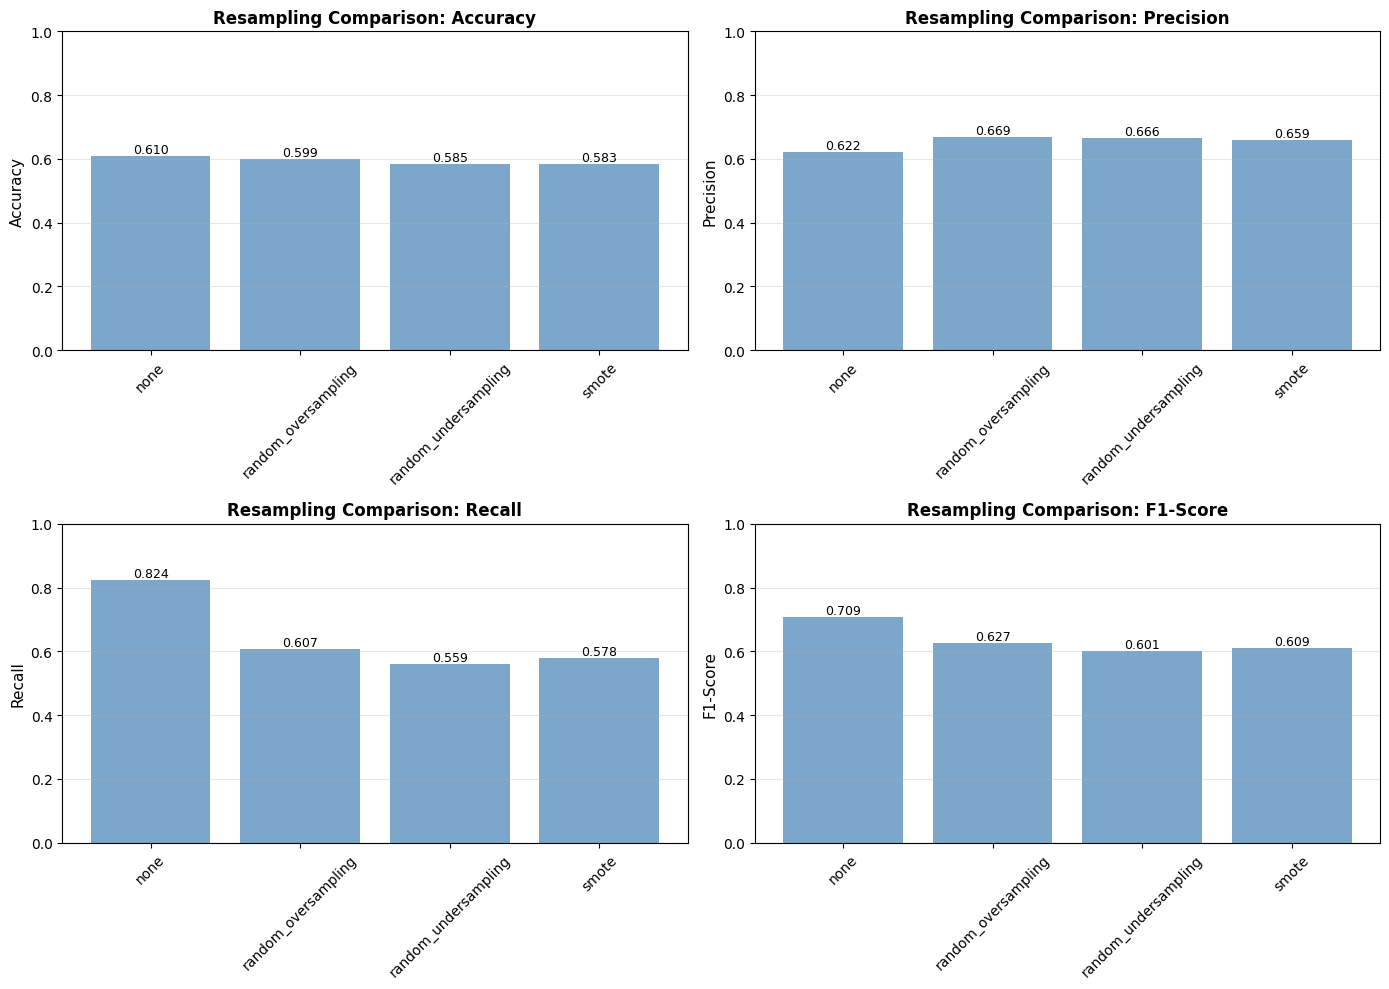

✓ Comparison plot saved as "resampling_comparison.png"


In [13]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Method'], values, color='steelblue', alpha=0.7)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'Resampling Comparison: {metric}', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('resampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Comparison plot saved as "resampling_comparison.png"')

# REQUIREMENT 2: ALGORITHM-LEVEL APPROACHES (CLASS WEIGHTING)

## 8. Compare Models WITH and WITHOUT Class Weighting


In [14]:
print('\n' + '='*80)
print('COMPARING CLASS WEIGHTING APPROACHES')
print('='*80)

# Calculate class weights
n_samples = len(y_train)
n_classes = 2
class_counts = np.bincount(y_train)
class_weights = n_samples / (n_classes * class_counts)
class_weight_dict = {i: class_weights[i] for i in range(n_classes)}

print(f'\nClass weights: {class_weight_dict}')

# Model configs: (name, algorithm, with_weights, without_weights)
models_config = [
    ('SVM', 'svm'),
    ('Random Forest', 'rf'),
    ('XGBoost', 'xgb')
]

results_weighting = {}

for model_name, algo_type in models_config:
    print(f'\n[{model_name}]')
    results_weighting[model_name] = {}

    for use_weights in [False, True]:
        weight_label = 'with_weights' if use_weights else 'without_weights'
        print(f"  {weight_label.replace('_', ' ').upper()}...")

        precisions = []
        recalls = []
        f1_scores = []
        accuracies = []

        skf = StratifiedKFold(n_splits=CONFIG['n_splits'], shuffle=True, random_state=CONFIG['random_state'])

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_fold_train = X_train[train_idx]
            y_fold_train = y_train[train_idx]
            X_fold_val = X_train[val_idx]
            y_fold_val = y_train[val_idx]

            # Create classifier based on algorithm type
            if algo_type == 'svm':
                clf = SVC(
                    kernel='rbf',
                    class_weight='balanced' if use_weights else None,
                    random_state=CONFIG['random_state']
                )

            elif algo_type == 'rf':
                clf = RandomForestClassifier(
                    n_estimators=100,
                    class_weight='balanced' if use_weights else None,
                    random_state=CONFIG['random_state']
                )

            elif algo_type == 'xgb':
                scale_pos_weight = class_weights[0] / class_weights[1] if use_weights else 1
                clf = xgb.XGBClassifier(
                    scale_pos_weight=scale_pos_weight,
                    random_state=CONFIG['random_state'],
                    verbosity=0
                )

            # Train
            clf.fit(X_fold_train, y_fold_train)

            # Evaluate
            y_pred = clf.predict(X_fold_val)

            precisions.append(precision_score(y_fold_val, y_pred, zero_division=0))
            recalls.append(recall_score(y_fold_val, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_fold_val, y_pred, zero_division=0))
            accuracies.append(accuracy_score(y_fold_val, y_pred))

        # Store results
        results_weighting[model_name][weight_label] = {
            'accuracy': np.mean(accuracies),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1': np.mean(f1_scores)
        }

        print(f"    Accuracy:  {np.mean(accuracies):.4f}")
        print(f"    Precision: {np.mean(precisions):.4f}")
        print(f"    Recall:    {np.mean(recalls):.4f}")
        print(f"    F1-Score:  {np.mean(f1_scores):.4f}")


COMPARING CLASS WEIGHTING APPROACHES

Class weights: {0: np.float64(1.1797235023041475), 1: np.float64(0.8677966101694915)}

[SVM]
  WITHOUT WEIGHTS...
    Accuracy:  0.6104
    Precision: 0.6224
    Recall:    0.8237
    F1-Score:  0.7088
  WITH WEIGHTS...
    Accuracy:  0.5850
    Precision: 0.6698
    Recall:    0.5576
    F1-Score:  0.6002

[Random Forest]
  WITHOUT WEIGHTS...
    Accuracy:  0.6211
    Precision: 0.6487
    Recall:    0.7475
    F1-Score:  0.6939
  WITH WEIGHTS...
    Accuracy:  0.6231
    Precision: 0.6483
    Recall:    0.7593
    F1-Score:  0.6982

[XGBoost]
  WITHOUT WEIGHTS...
    Accuracy:  0.6172
    Precision: 0.6510
    Recall:    0.7254
    F1-Score:  0.6853
  WITH WEIGHTS...
    Accuracy:  0.6133
    Precision: 0.6442
    Recall:    0.7339
    F1-Score:  0.6855


### Analyze Precision-Recall Trade-off


In [15]:
print('\n' + '='*80)
print('PRECISION-RECALL TRADE-OFF ANALYSIS')
print('='*80)

for model_name in results_weighting:
    without = results_weighting[model_name]['without_weights']
    with_w = results_weighting[model_name]['with_weights']

    print(f'\n{model_name}:')
    print(f'  WITHOUT Weights:')
    print(f"    Precision: {without['precision']:.4f}, Recall: {without['recall']:.4f}")
    print(f'  WITH Weights:')
    print(f"    Precision: {with_w['precision']:.4f}, Recall: {with_w['recall']:.4f}")

    prec_change = with_w['precision'] - without['precision']
    rec_change = with_w['recall'] - without['recall']

    print(f'  Changes:')
    print(f"    Precision: {prec_change:+.4f}")
    print(f"    Recall:    {rec_change:+.4f}")

    if prec_change < 0 and rec_change > 0:
        print('    → Class weighting REDUCES precision but INCREASES recall')
        print('      (catches more positive cases, but more false positives)')
    elif prec_change > 0 and rec_change < 0:
        print('    → Class weighting INCREASES precision but REDUCES recall')
    else:
        print('    → Mixed trade-off')


PRECISION-RECALL TRADE-OFF ANALYSIS

SVM:
  WITHOUT Weights:
    Precision: 0.6224, Recall: 0.8237
  WITH Weights:
    Precision: 0.6698, Recall: 0.5576
  Changes:
    Precision: +0.0474
    Recall:    -0.2661
    → Class weighting INCREASES precision but REDUCES recall

Random Forest:
  WITHOUT Weights:
    Precision: 0.6487, Recall: 0.7475
  WITH Weights:
    Precision: 0.6483, Recall: 0.7593
  Changes:
    Precision: -0.0005
    Recall:    +0.0119
    → Class weighting REDUCES precision but INCREASES recall
      (catches more positive cases, but more false positives)

XGBoost:
  WITHOUT Weights:
    Precision: 0.6510, Recall: 0.7254
  WITH Weights:
    Precision: 0.6442, Recall: 0.7339
  Changes:
    Precision: -0.0069
    Recall:    +0.0085
    → Class weighting REDUCES precision but INCREASES recall
      (catches more positive cases, but more false positives)


### Visualize Class Weighting Impact


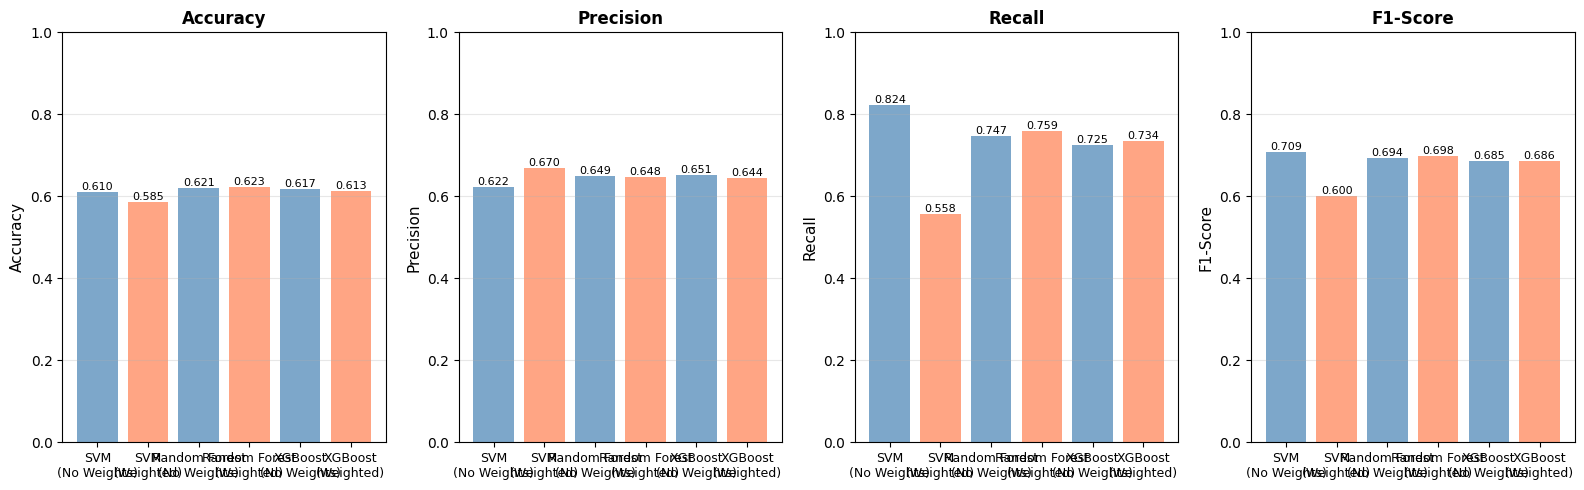

✓ Class weighting plot saved as "class_weighting_comparison.png"


In [16]:
# Create comparison dataframe
weighting_data = []
for model_name in results_weighting:
    without = results_weighting[model_name]['without_weights']
    with_w = results_weighting[model_name]['with_weights']

    weighting_data.append({
        'Model': f"{model_name}\n(No Weights)",
        'Accuracy': without['accuracy'],
        'Precision': without['precision'],
        'Recall': without['recall'],
        'F1-Score': without['f1']
    })

    weighting_data.append({
        'Model': f"{model_name}\n(Weighted)",
        'Accuracy': with_w['accuracy'],
        'Precision': with_w['precision'],
        'Recall': with_w['recall'],
        'F1-Score': with_w['f1']
    })

weighting_df = pd.DataFrame(weighting_data)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = weighting_df[metric].values
    x_pos = np.arange(len(weighting_df))

    bars = ax.bar(x_pos, values, color=['steelblue', 'coral'] * 3, alpha=0.7)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(weighting_df['Model'], fontsize=9)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('class_weighting_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Class weighting plot saved as "class_weighting_comparison.png"')

## 9. Final Model Evaluation on Test Set


In [17]:
print('\n' + '='*80)
print('FINAL TEST SET EVALUATION')
print('='*80)

# Train best model on full training set
best_clf = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=CONFIG['random_state']
)

best_clf.fit(X_train, y_train)

# Predict on test set
y_pred_test = best_clf.predict(X_test)
y_pred_proba_test = best_clf.predict_proba(X_test)[:, 1]

# Metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f'\nSVM with Class Weighting - Test Set Results:')
print(f'  Accuracy:  {test_accuracy:.4f}')
print(f'  Precision: {test_precision:.4f}')
print(f'  Recall:    {test_recall:.4f}')
print(f'  F1-Score:  {test_f1:.4f}')
print(f'  ROC AUC:   {test_roc_auc:.4f}')

print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_test, target_names=['Low Arousal', 'High Arousal']))

print(f'\nConfusion Matrix:')
cm = confusion_matrix(y_test, y_pred_test)
print(cm)


FINAL TEST SET EVALUATION

SVM with Class Weighting - Test Set Results:
  Accuracy:  0.6250
  Precision: 0.7008
  Recall:    0.6054
  F1-Score:  0.6496
  ROC AUC:   0.6592

Classification Report:
              precision    recall  f1-score   support

 Low Arousal       0.55      0.65      0.60       109
High Arousal       0.70      0.61      0.65       147

    accuracy                           0.62       256
   macro avg       0.63      0.63      0.62       256
weighted avg       0.64      0.62      0.63       256


Confusion Matrix:
[[71 38]
 [58 89]]


### Plot Confusion Matrix


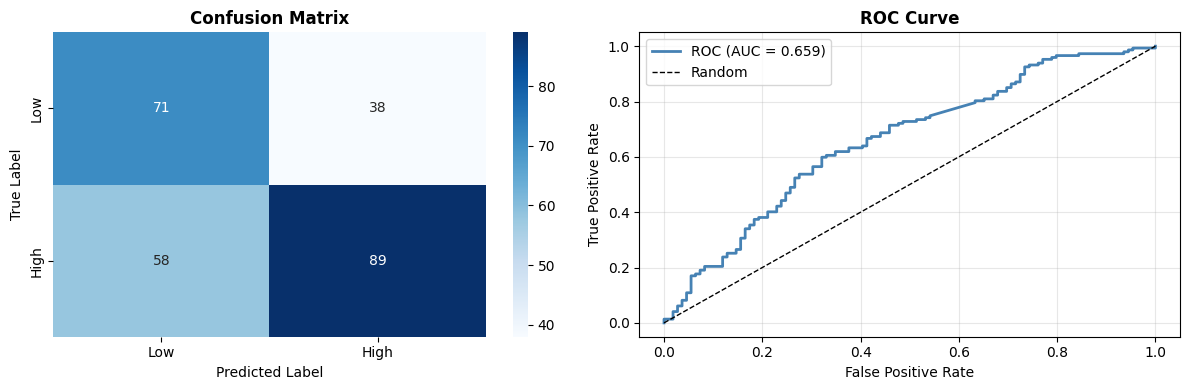

✓ Results plot saved as "final_results.png"


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
axes[0].set_title('Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
axes[1].plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC (AUC = {test_roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('final_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Results plot saved as "final_results.png"')

## 10. BONUS CHALLENGES (Optional Extra Credit)


### BONUS 1: Multi-class Classification

Try dividing arousal into 3 or more levels instead of binary classification.


In [ ]:
y_multiclass = np.digitize(y, bins=[4, 6])

# Analyze class distribution
unique, counts = np.unique(y_multiclass, return_counts=True)
class_dist_multiclass = dict(zip(unique, counts))

print('\n' + '='*60)
print('MULTI-CLASS DISTRIBUTION')
print('='*60)
print(f'Class 0 (<=4): {class_dist_multiclass.get(0, 0):3d} samples ({100*class_dist_multiclass.get(0, 0)/len(y_multiclass):5.1f}%)')
print(f'Class 1 (4-6): {class_dist_multiclass.get(1, 0):3d} samples ({100*class_dist_multiclass.get(1, 0)/len(y_multiclass):5.1f}%)')
print(f'Class 2 (>6):  {class_dist_multiclass.get(2, 0):3d} samples ({100*class_dist_multiclass.get(2, 0)/len(y_multiclass):5.1f}%)')


MULTI-CLASS DISTRIBUTION
Class 0 (<=4): 368 samples ( 28.8%)
Class 1 (4-6): 380 samples ( 29.7%)
Class 2 (>6):  532 samples ( 41.6%)


In [25]:
# Multi-class example: 3-level classification
print('\n' + '='*60)
print('BONUS 1: MULTI-CLASS CLASSIFICATION')
print('='*60)

# Split data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multiclass,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_multiclass
)

# Scale features
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

print(f'\nTrain set: {X_train_m.shape[0]} samples')
print(f'Test set:  {X_test_m.shape[0]} samples')
print(f'Features:  {X_train_m.shape[1]}')

# Check train/test balance
train_dist = np.bincount(y_train_m)
test_dist = np.bincount(y_test_m)
print(f'\nTrain - Low: {train_dist[0]}, Mefium: {train_dist[1]}, High: {test_dist[2]}')
print(f'Test  - Low: {test_dist[0]}, Medium: {test_dist[1]}, High: {test_dist[2]}')


BONUS 1: MULTI-CLASS CLASSIFICATION

Train set: 1024 samples
Test set:  256 samples
Features:  640

Train - Low: 294, Mefium: 304, High: 106
Test  - Low: 74, Medium: 76, High: 106


In [31]:
# Evaluate each resampling method with stratified K-fold
resampling_methods = ['none', 'random_oversampling', 'random_undersampling', 'smote']
results_resampling = {}

print('\n' + '='*80)
print('COMPARING RESAMPLING TECHNIQUES')
print('Using: Stratified 5-Fold Cross-Validation')
print('='*80)

for method in resampling_methods:
    print(f'\n[{method.upper()}]')

    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []
    roc_aucs = []

    skf = StratifiedKFold(n_splits=CONFIG['n_splits'], shuffle=True, random_state=CONFIG['random_state'])

    for fold_idx, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train_m, y_train_m), total=CONFIG['n_splits'])):
        # Get train/val splits
        X_fold_train_m = X_train_m[train_idx]
        y_fold_train_m = y_train_m[train_idx]
        X_fold_val_m = X_train_m[val_idx]
        y_fold_val_m = y_train_m[val_idx]

        # CRITICAL: Apply resampling ONLY to training fold, NOT validation
        X_fold_train_m_resampled, y_fold_train_m_resampled = apply_resampling(
            X_fold_train_m, y_fold_train_m, method=method
        )

        # Train classifier
        clf = SVC(kernel='rbf', probability=True, random_state=CONFIG['random_state'])
        clf.fit(X_fold_train_m_resampled, y_fold_train_m_resampled)

        # Evaluate on ORIGINAL validation fold (not resampled)
        y_pred_m = clf.predict(X_fold_val_m)
        y_pred_m_proba = clf.predict_proba(X_fold_val_m)

        precisions.append(precision_score(y_fold_val_m, y_pred_m, average='weighted', zero_division=0))
        recalls.append(recall_score(y_fold_val_m, y_pred_m, average='weighted', zero_division=0))
        f1_scores.append(f1_score(y_fold_val_m, y_pred_m, average='weighted', zero_division=0))
        accuracies.append(accuracy_score(y_fold_val_m, y_pred_m))

        try:
            # For multi-class ROC AUC, need multi_class='ovr' or 'ovo' and specify average
            roc_aucs.append(roc_auc_score(y_fold_val_m, y_pred_m_proba, multi_class='ovr', average='weighted'))
        except ValueError as e:
            print(f"  ⚠ Could not calculate ROC AUC for method {method}, fold {fold_idx}: {e}")
            roc_aucs.append(np.nan) # Append NaN if calculation fails


    # Store results
    results_resampling[method] = {
        'accuracy': np.nanmean(accuracies), # Use nanmean to handle potential NaNs from ROC AUC errors
        'accuracy_std': np.nanstd(accuracies),
        'precision': np.nanmean(precisions),
        'precision_std': np.nanstd(precisions),
        'recall': np.nanmean(recalls),
        'recall_std': np.nanstd(recalls),
        'f1': np.nanmean(f1_scores),
        'f1_std': np.nanstd(f1_scores),
        'roc_auc': np.nanmean(roc_aucs),
        'roc_auc_std': np.nanstd(roc_aucs)
    }

    print(f"  Accuracy:  {np.nanmean(accuracies):.4f} ± {np.nanstd(accuracies):.4f}")
    print(f"  Precision: {np.nanmean(precisions):.4f} ± {np.nanstd(precisions):.4f}")
    print(f"  Recall:    {np.nanmean(recalls):.4f} ± {np.nanstd(recalls):.4f}")
    print(f"  F1-Score:  {np.nanmean(f1_scores):.4f} ± {np.nanstd(f1_scores):.4f}")
    print(f"  ROC AUC:   {np.nanmean(roc_aucs):.4f} ± {np.nanstd(roc_aucs):.4f}")


COMPARING RESAMPLING TECHNIQUES
Using: Stratified 5-Fold Cross-Validation

[NONE]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.4668 ± 0.0236
  Precision: 0.4606 ± 0.0258
  Recall:    0.4668 ± 0.0236
  F1-Score:  0.4459 ± 0.0216
  ROC AUC:   0.6377 ± 0.0150

[RANDOM_OVERSAMPLING]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.4443 ± 0.0322
  Precision: 0.4628 ± 0.0299
  Recall:    0.4443 ± 0.0322
  F1-Score:  0.4422 ± 0.0328
  ROC AUC:   0.6343 ± 0.0194

[RANDOM_UNDERSAMPLING]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.4502 ± 0.0257
  Precision: 0.4789 ± 0.0263
  Recall:    0.4502 ± 0.0257
  F1-Score:  0.4473 ± 0.0301
  ROC AUC:   0.6279 ± 0.0228

[SMOTE]


  0%|          | 0/5 [00:00<?, ?it/s]

  Accuracy:  0.4590 ± 0.0265
  Precision: 0.4851 ± 0.0223
  Recall:    0.4590 ± 0.0265
  F1-Score:  0.4553 ± 0.0310
  ROC AUC:   0.6402 ± 0.0213


In [32]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': list(results_resampling.keys()),
    'Accuracy': [results_resampling[m]['accuracy'] for m in results_resampling],
    'Precision': [results_resampling[m]['precision'] for m in results_resampling],
    'Recall': [results_resampling[m]['recall'] for m in results_resampling],
    'F1-Score': [results_resampling[m]['f1'] for m in results_resampling],
    'ROC-AUC': [results_resampling[m]['roc_auc'] for m in results_resampling]
})

print('\n' + '='*80)
print('RESAMPLING COMPARISON TABLE')
print('='*80)
print(comparison_df.to_string(index=False))

# Find best method
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_method = comparison_df.loc[best_f1_idx, 'Method']
print(f'\n✓ Best Method (by F1-Score): {best_method}')


RESAMPLING COMPARISON TABLE
              Method  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                none  0.466777   0.460590 0.466777  0.445901 0.637675
 random_oversampling  0.444290   0.462764 0.444290  0.442191 0.634288
random_undersampling  0.450177   0.478919 0.450177  0.447342 0.627949
               smote  0.458972   0.485068 0.458972  0.455322 0.640244

✓ Best Method (by F1-Score): smote


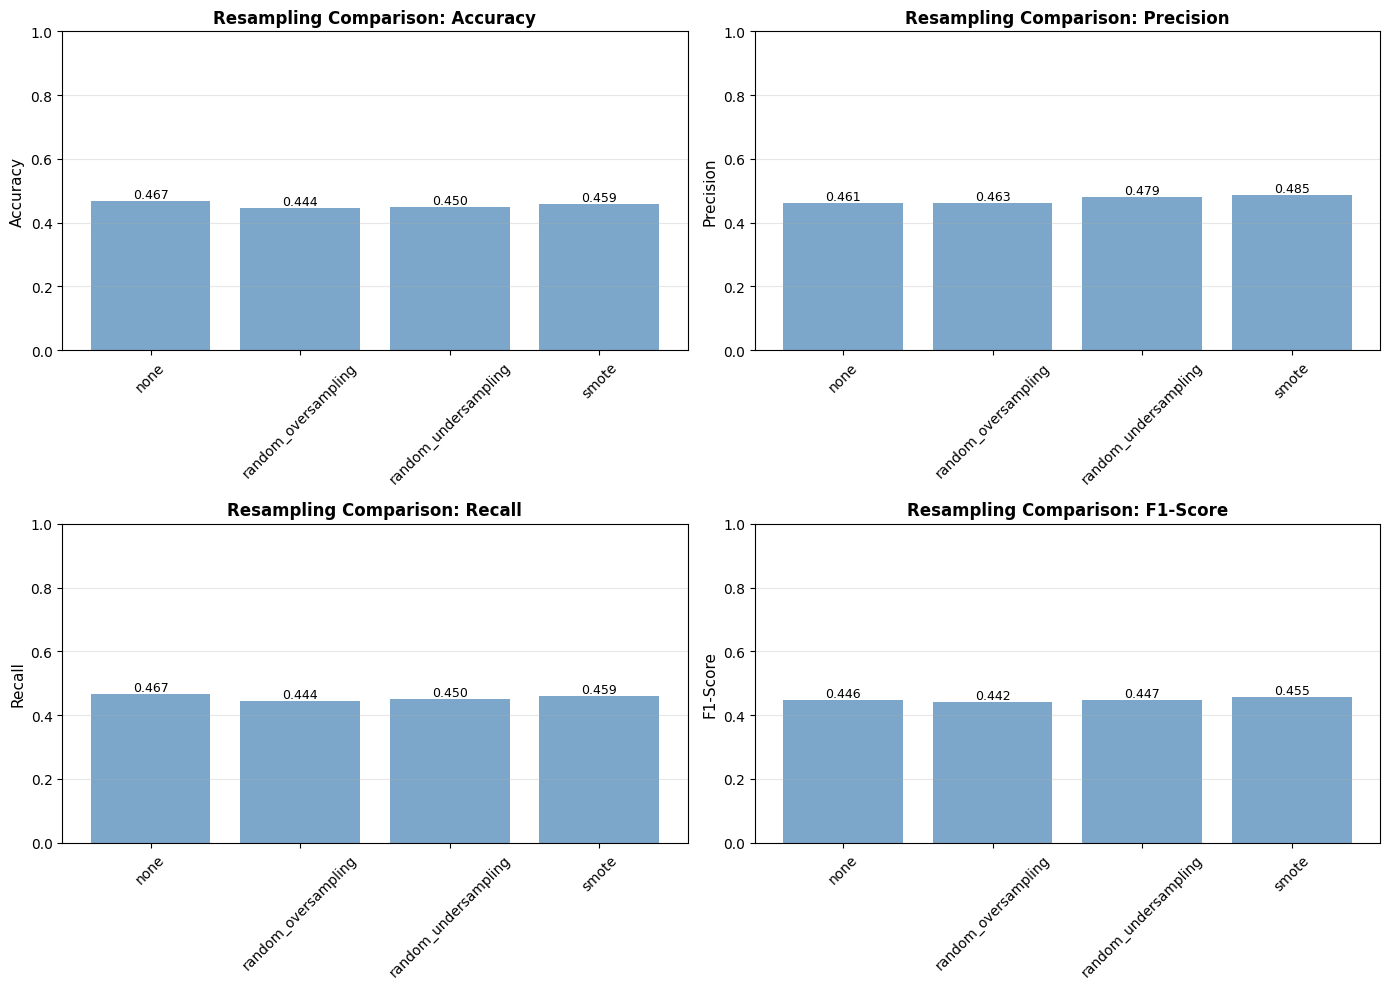

✓ Comparison plot saved as "resampling_comparison.png"


In [33]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Method'], values, color='steelblue', alpha=0.7)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'Resampling Comparison: {metric}', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('resampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Comparison plot saved as "resampling_comparison.png"')

### BONUS 2: Feature Engineering

Extract additional EEG features or apply dimensionality reduction.


In [34]:
from sklearn.decomposition import PCA

print('\n' + '='*60)
print('BONUS 2: FEATURE ENGINEERING WITH PCA')
print('='*60)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f'\nOriginal features: {X_train.shape[1]}')
print(f'PCA features: {X_train_pca.shape[1]}')
print(f'Variance explained: {pca.explained_variance_ratio_.sum():.4f}')

# Train model with PCA features
clf_pca = SVC(kernel='rbf', class_weight='balanced', random_state=CONFIG['random_state'])
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f'\nTest Accuracy with PCA: {acc_pca:.4f}')
print(f'Original Accuracy: {test_accuracy:.4f}')
print(f'Difference: {acc_pca - test_accuracy:+.4f}')


BONUS 2: FEATURE ENGINEERING WITH PCA

Original features: 640
PCA features: 37
Variance explained: 0.9524

Test Accuracy with PCA: 0.6250
Original Accuracy: 0.6250
Difference: +0.0000


### BONUS 3: Subject-Specific vs Subject-Independent Models

Compare models trained on specific subjects vs general models.


In [21]:
print('\n' + '='*60)
print('BONUS 3: SUBJECT-SPECIFIC VS SUBJECT-INDEPENDENT')
print('='*60)
print('\nSubject-specific approach:')
print('  Train separate model for each subject')
print('  Pros: Personalized, captures individual differences')
print('  Cons: Requires data per subject, doesn\'t generalize')
print('\nSubject-independent approach:')
print('  Train one model on all subjects')
print('  Pros: Generalizes to new subjects')
print('  Cons: Less accurate for specific individuals')
print('\nTODO: Evaluate both approaches')
print('  Use Leave-One-Subject-Out (LOSO) cross-validation')


BONUS 3: SUBJECT-SPECIFIC VS SUBJECT-INDEPENDENT

Subject-specific approach:
  Train separate model for each subject
  Pros: Personalized, captures individual differences
  Cons: Requires data per subject, doesn't generalize

Subject-independent approach:
  Train one model on all subjects
  Pros: Generalizes to new subjects
  Cons: Less accurate for specific individuals

TODO: Evaluate both approaches
  Use Leave-One-Subject-Out (LOSO) cross-validation


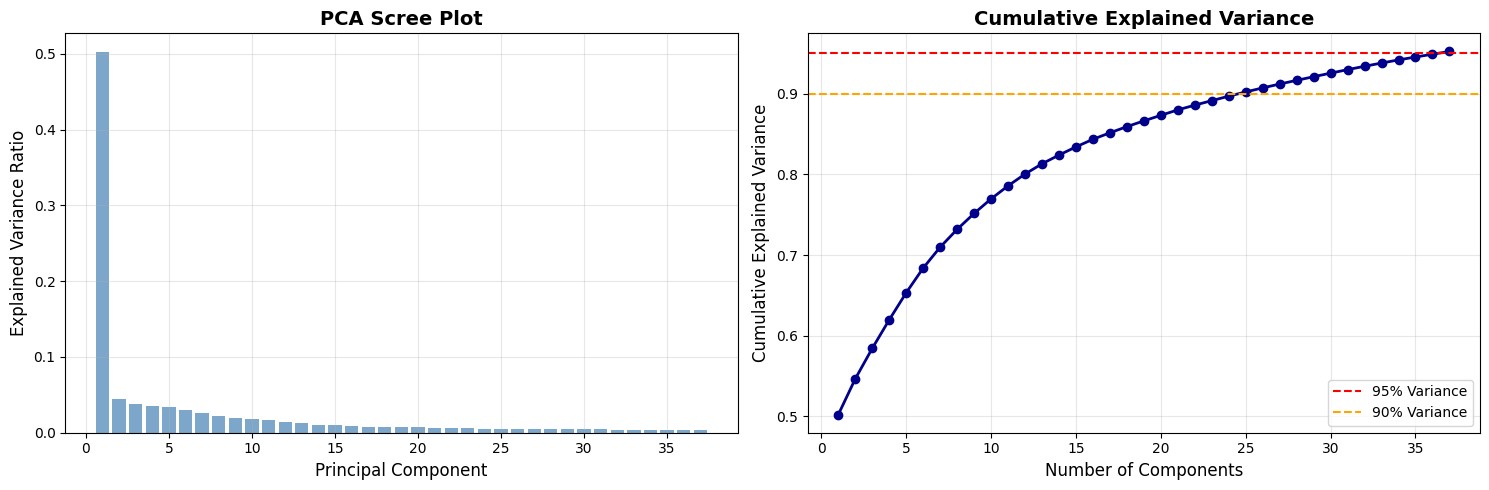


Components needed for 90% variance: 25
Components needed for 95% variance: 37


In [35]:
# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='darkblue', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components needed for 90% and 95% variance
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

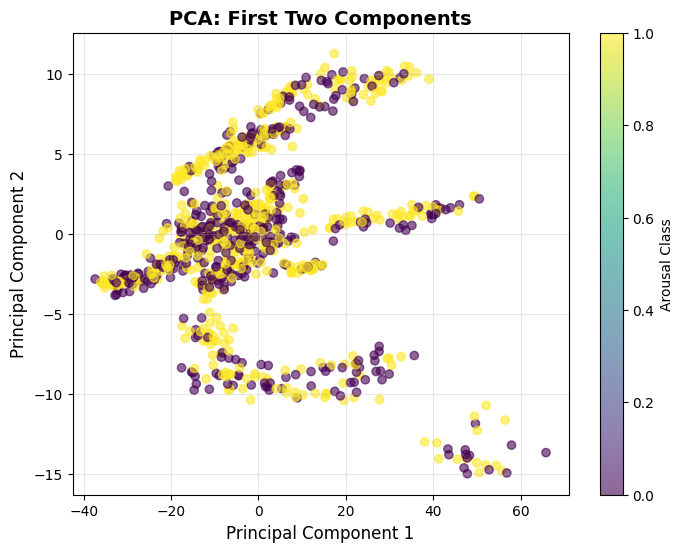

In [36]:
# Plot the first 2 principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('PCA: First Two Components', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Arousal Class')
plt.grid(True, alpha=0.3)
plt.show()

# Task 3: Ensemble Methods

In [39]:
# Calculate class weight ratio for XGBoost
class_weight_ratio = train_dist[0] / train_dist[1]

print(f'\n' + '='*70)
print('BONUS TASK 3 & 4 SETUP')
print('='*70)
print(f'Class weight ratio for XGBoost: {class_weight_ratio:.4f}')
print(f'(This balances the {class_dist[0]} negative samples vs {class_dist[1]} positive samples)')

# Store scaled data for later use
X_train_scaled = X_train
X_test_scaled = X_test

print(f'✓ Setup complete - Ready for ensemble and temporal analysis')


BONUS TASK 3 & 4 SETUP
Class weight ratio for XGBoost: 0.9671
(This balances the 543 negative samples vs 737 positive samples)
✓ Setup complete - Ready for ensemble and temporal analysis



BONUS TASK 3: ENSEMBLE METHODS - Combining Multiple Models

1. VOTING CLASSIFIER
--------------------------------------------------
Voting Hard Voting (Hard):
  F1 Scores: 0.6914 (+/- 0.0390)

Voting Soft Voting (Soft):
  F1 Scores: 0.6980 (+/- 0.0334)

Test Set Performance (Voting Hard):
  Accuracy: 0.6406
  F1 Score: 0.7125
  ROC-AUC: 0.6315

Test Set Performance (Voting Soft):
  Accuracy: 0.6016
  F1 Score: 0.6909
  ROC-AUC: 0.6315

2. STACKING CLASSIFIER
--------------------------------------------------
Stacking Classifier (with Logistic Regression meta-learner):
  F1 Scores: 0.6412 (+/- 0.0315)

Test Set Performance (Stacking):
  Accuracy: 0.6016
  F1 Score: 0.6483
  ROC-AUC: 0.6365

3. GRADIENT BOOSTING CLASSIFIER
--------------------------------------------------
Gradient Boosting Classifier:
  F1 Scores: 0.6931 (+/- 0.0529)

Test Set Performance (Gradient Boosting):
  Accuracy: 0.6055
  F1 Score: 0.6773
  ROC-AUC: 0.6338

4. ENSEMBLE METHODS COMPARISON
-----------------------

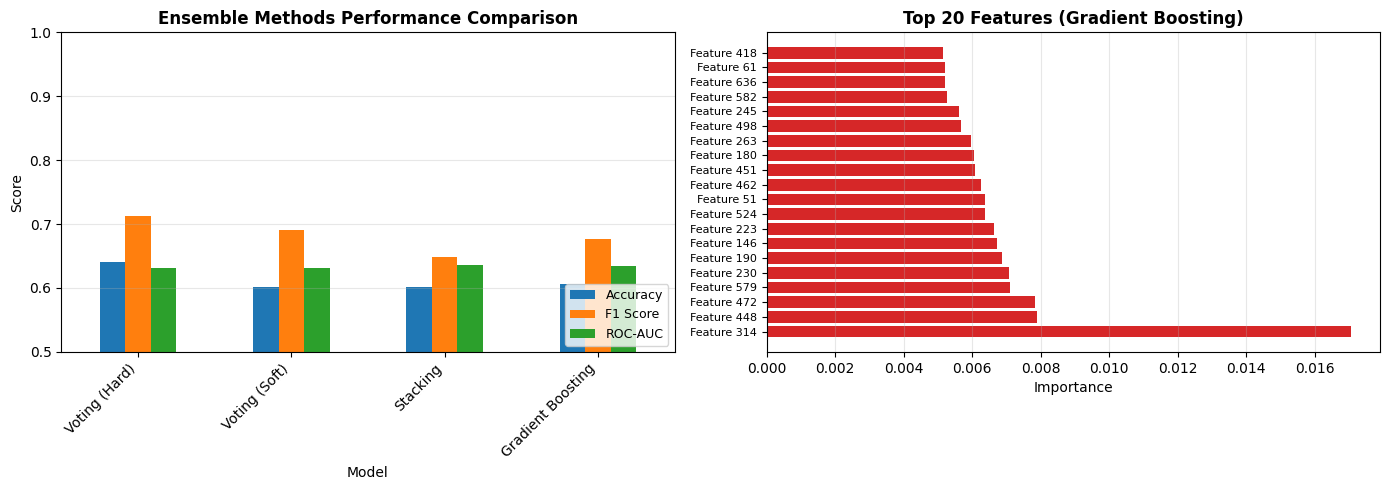


✓ Ensemble methods analysis completed!


In [44]:
# Bonus Task 3: Ensemble Methods - Combining Multiple Models
print("\n" + "="*70)
print("BONUS TASK 3: ENSEMBLE METHODS - Combining Multiple Models")
print("="*70)

from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Initialize base models
svc_model = SVC(kernel='rbf', C=100, gamma='scale', class_weight='balanced', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                               scale_pos_weight=class_weight_ratio, random_state=42, verbosity=0)

# 1. Voting Classifier (Hard & Soft)
print("\n1. VOTING CLASSIFIER")
print("-" * 50)

voting_hard = VotingClassifier(
    estimators=[('svc', svc_model), ('rf', rf_model), ('xgb', xgb_model)],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[('svc', svc_model), ('rf', rf_model), ('xgb', xgb_model)],
    voting='soft'
)

# Cross-validation for Voting Classifiers
skf = StratifiedKFold(n_splits=CONFIG['n_splits'], shuffle=True, random_state=CONFIG['random_state'])

# Use X_train_scaled and y_train for cross-validation
scores_voting_hard = cross_val_score(voting_hard, X_train_scaled, y_train, cv=skf, scoring='f1')
scores_voting_soft = cross_val_score(voting_soft, X_train_scaled, y_train, cv=skf, scoring='f1')

print(f"Voting Hard Voting (Hard):")
print(f"  F1 Scores: {scores_voting_hard.mean():.4f} (+/- {scores_voting_hard.std():.4f})")


print(f"\nVoting Soft Voting (Soft):")
print(f"  F1 Scores: {scores_voting_soft.mean():.4f} (+/- {scores_voting_soft.std():.4f})")


# Train on full training set and evaluate on test set
voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

y_pred_voting_hard = voting_hard.predict(X_test_scaled)
y_pred_voting_soft = voting_soft.predict(X_test_scaled)

print(f"\nTest Set Performance (Voting Hard):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_voting_hard):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_voting_hard):.4f}")
# Use predict_proba for ROC-AUC, requires voting='soft' or base models with predict_proba
# For hard voting, we can't directly get aggregated probabilities for ROC AUC
# We'll calculate ROC AUC for the soft voting classifier
print(f"  ROC-AUC: {roc_auc_score(y_test, voting_soft.predict_proba(X_test_scaled)[:, 1]):.4f}")


print(f"\nTest Set Performance (Voting Soft):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_voting_soft):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_voting_soft):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, voting_soft.predict_proba(X_test_scaled)[:, 1]):.4f}")


# 2. Stacking Classifier
print("\n2. STACKING CLASSIFIER")
print("-" * 50)

base_models = [
    ('svc', SVC(kernel='rbf', C=100, gamma='scale', class_weight='balanced', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                              scale_pos_weight=class_weight_ratio, random_state=42, verbosity=0))
]

meta_learner = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

# Use X_train_scaled and y_train for cross-validation
scores_stacking = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=skf, scoring='f1')

print(f"Stacking Classifier (with Logistic Regression meta-learner):")
print(f"  F1 Scores: {scores_stacking.mean():.4f} (+/- {scores_stacking.std():.4f})")


stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)

print(f"\nTest Set Performance (Stacking):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_stacking):.4f}")
# Ensure meta_learner supports predict_proba
print(f"  ROC-AUC: {roc_auc_score(y_test, stacking_clf.predict_proba(X_test_scaled)[:, 1]):.4f}")


# 3. Gradient Boosting Ensemble
print("\n3. GRADIENT BOOSTING CLASSIFIER")
print("-" * 50)

gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

# Use X_train_scaled and y_train for cross-validation
scores_gb = cross_val_score(gb_clf, X_train_scaled, y_train, cv=skf, scoring='f1')

print(f"Gradient Boosting Classifier:")
print(f"  F1 Scores: {scores_gb.mean():.4f} (+/- {scores_gb.std():.4f})")


gb_clf.fit(X_train_scaled, y_train)
y_pred_gb = gb_clf.predict(X_test_scaled)

print(f"\nTest Set Performance (Gradient Boosting):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, gb_clf.predict_proba(X_test_scaled)[:, 1]):.4f}")


# Comparison of all ensemble methods
print("\n4. ENSEMBLE METHODS COMPARISON")
print("-" * 50)

ensemble_results = pd.DataFrame({
    'Model': ['Voting (Hard)', 'Voting (Soft)', 'Stacking', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_voting_hard),
        accuracy_score(y_test, y_pred_voting_soft),
        accuracy_score(y_test, y_pred_stacking),
        accuracy_score(y_test, y_pred_gb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_voting_hard),
        f1_score(y_test, y_pred_voting_soft),
        f1_score(y_test, y_pred_stacking),
        f1_score(y_test, y_pred_gb)
    ],
    'ROC-AUC': [
        # Use predict_proba for ROC-AUC, requires voting='soft' or base models with predict_proba
        roc_auc_score(y_test, voting_soft.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, voting_soft.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, stacking_clf.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, gb_clf.predict_proba(X_test_scaled)[:, 1])
    ]
})

print(ensemble_results.to_string(index=False))

# Visualize ensemble methods performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ensemble_results.set_index('Model')[['Accuracy', 'F1 Score', 'ROC-AUC']].plot(
    kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
axes[0].set_title('Ensemble Methods Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=10)
axes[0].set_xlabel('Model', fontsize=10)
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Feature importance from Gradient Boosting
gb_importance = pd.DataFrame({
    'Feature Index': range(len(gb_clf.feature_importances_)),
    'Importance': gb_clf.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

axes[1].barh(range(len(gb_importance)), gb_importance['Importance'].values, color='#d62728')
axes[1].set_yticks(range(len(gb_importance)))
axes[1].set_yticklabels([f"Feature {i}" for i in gb_importance['Feature Index'].values], fontsize=8)
axes[1].set_xlabel('Importance', fontsize=10)
axes[1].set_title('Top 20 Features (Gradient Boosting)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Ensemble methods analysis completed!")

# Task4 : Temporal Analysis


BONUS TASK 4: TEMPORAL ANALYSIS - Arousal Changes Over Time

1. TEMPORAL FEATURE EXTRACTION
--------------------------------------------------
Extracting temporal features for training data...


Training:   0%|          | 0/1024 [00:00<?, ?it/s]

Extracting temporal features for test data...


Testing:   0%|          | 0/256 [00:00<?, ?it/s]

✓ Training data: 1024 trials with 20 segments each
✓ Test data: 256 trials with 20 segments each

2. TEMPORAL PATTERN ANALYSIS - Computing Temporal Profiles
--------------------------------------------------
Low arousal temporal profile: shape (20, 32)
High arousal temporal profile: shape (20, 32)
Mean DE values - Low: [0.37855567 0.         0.         0.         0.        ] ...
Mean DE values - High: [0.38010016 0.         0.         0.         0.        ] ...

3. TEMPORAL VISUALIZATION
--------------------------------------------------


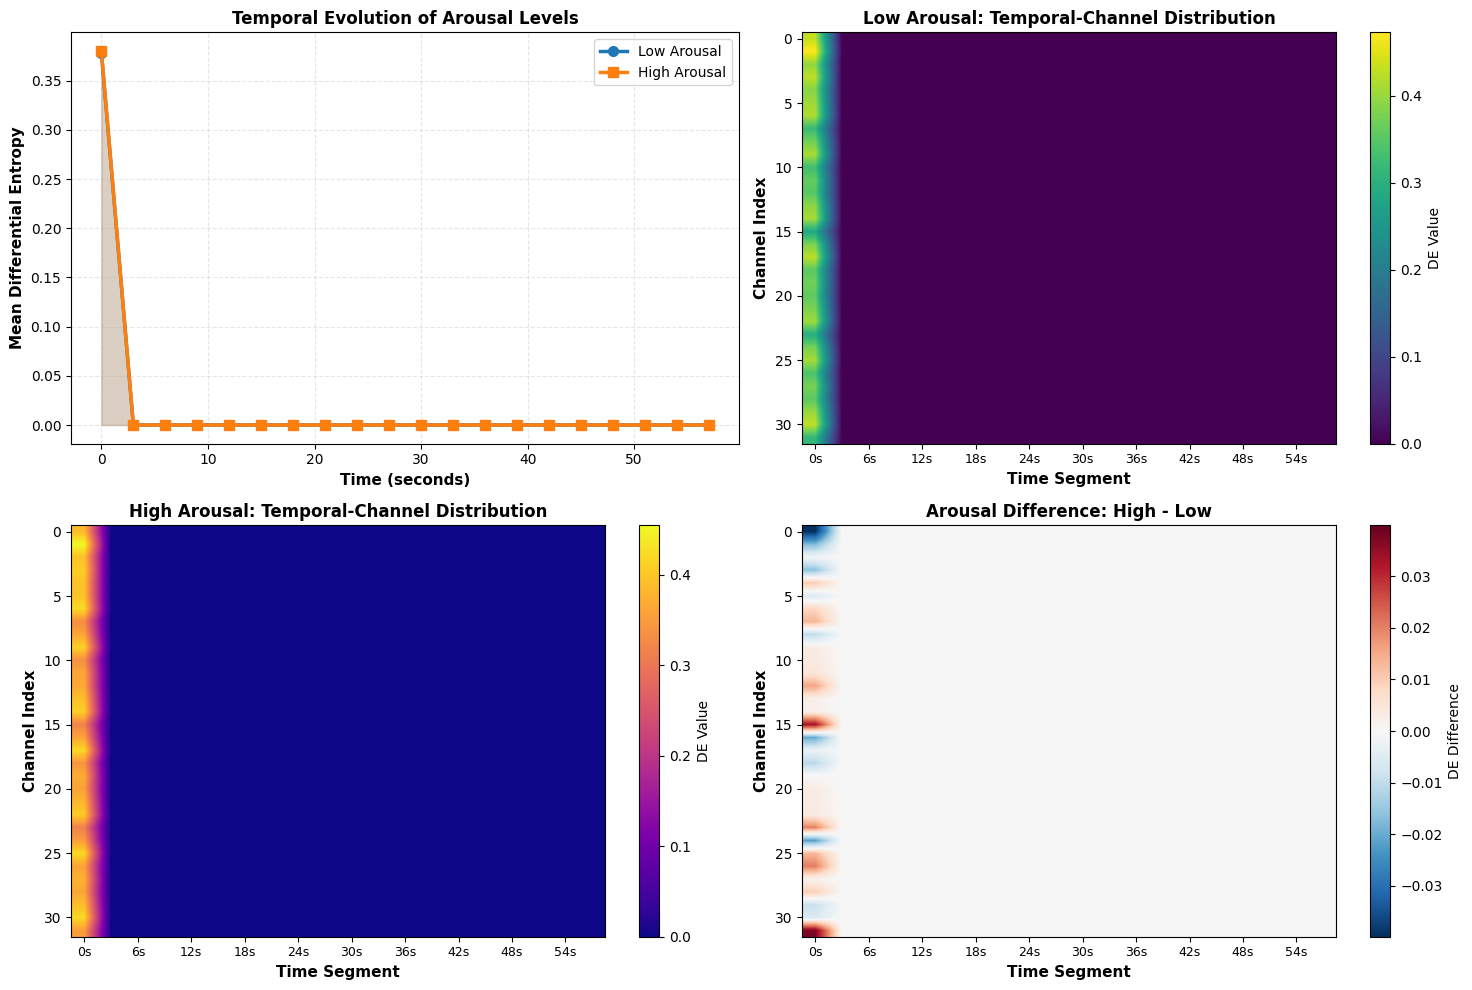


4. TEMPORAL STATISTICS
--------------------------------------------------
 Time (s)  Low Arousal DE  High Arousal DE  Difference  Ratio (H/L)
        0        0.378556           0.3801    0.001544      1.00408
        3        0.000000           0.0000    0.000000      0.00000
        6        0.000000           0.0000    0.000000      0.00000
        9        0.000000           0.0000    0.000000      0.00000
       12        0.000000           0.0000    0.000000      0.00000
       15        0.000000           0.0000    0.000000      0.00000
       18        0.000000           0.0000    0.000000      0.00000
       21        0.000000           0.0000    0.000000      0.00000
       24        0.000000           0.0000    0.000000      0.00000
       27        0.000000           0.0000    0.000000      0.00000
       30        0.000000           0.0000    0.000000      0.00000
       33        0.000000           0.0000    0.000000      0.00000
       36        0.000000           0.000

In [47]:
# Bonus Task 4: Temporal Analysis - CORRECTED VERSION
print("\n" + "="*70)
print("BONUS TASK 4: TEMPORAL ANALYSIS - Arousal Changes Over Time")
print("="*70)

# Re-extract features with temporal tracking
def extract_de_features_temporal(eeg_signal, num_segments=20, num_channels=32):
    """
    Extract DE features with temporal information.
    Returns: list of feature arrays (one per segment) and timestamps
    """
    features_temporal = []
    segment_timestamps = []
    segment_length = 3 * CONFIG['sampling_rate']  # 384 samples = 3 seconds

    for seg_idx in range(num_segments):
        start = seg_idx * segment_length
        end = start + segment_length
        time_point = seg_idx * 3  # Time in seconds

        segment_features = []
        for ch_idx in range(num_channels):
            segment_data = eeg_signal[ch_idx, start:end]
            de_value = calculate_differential_entropy(segment_data)
            segment_features.append(de_value)

        features_temporal.append(np.array(segment_features))
        segment_timestamps.append(time_point)

    return features_temporal, np.array(segment_timestamps)

print("\n1. TEMPORAL FEATURE EXTRACTION")
print("-" * 50)

# Re-perform train-test split to get original indices
X_train_orig, X_test_orig, y_train_orig, y_test_orig, train_indices, test_indices = train_test_split(
    X, y_binary,
    np.arange(X.shape[0]),
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_binary
)

# Extract temporal features - store as list of (trial_features, label) pairs
temporal_train_data = []
temporal_test_data = []

print("Extracting temporal features for training data...")
for original_idx in trange(len(train_indices), desc="Training"):
    data_idx = train_indices[original_idx]
    features_temp, timestamps = extract_de_features_temporal(
        X[data_idx].reshape(32, -1)
    )
    label = y_binary[data_idx]
    temporal_train_data.append((features_temp, label))

print("Extracting temporal features for test data...")
for original_idx in trange(len(test_indices), desc="Testing"):
    data_idx = test_indices[original_idx]
    features_temp, timestamps = extract_de_features_temporal(
        X[data_idx].reshape(32, -1)
    )
    label = y_binary[data_idx]
    temporal_test_data.append((features_temp, label))

print(f"✓ Training data: {len(temporal_train_data)} trials with 20 segments each")
print(f"✓ Test data: {len(temporal_test_data)} trials with 20 segments each")

# 2. Temporal Pattern Analysis - CORRECT APPROACH
print("\n2. TEMPORAL PATTERN ANALYSIS - Computing Temporal Profiles")
print("-" * 50)

n_segments = 20
n_channels = 32

# Initialize accumulators for temporal profiles
low_arousal_temporal = np.zeros((n_segments, n_channels))
high_arousal_temporal = np.zeros((n_segments, n_channels))
low_arousal_count = 0
high_arousal_count = 0

# Aggregate features by time segment and class
for trial_features, label in temporal_train_data:
    # trial_features is a list of 20 arrays (one per segment)
    for seg_idx, seg_features in enumerate(trial_features):
        if label == 0:
            low_arousal_temporal[seg_idx] += seg_features
            low_arousal_count += 1
        else:
            high_arousal_temporal[seg_idx] += seg_features
            high_arousal_count += 1

# Correct averaging: divide by number of samples in each class across all segments
n_low_trials = np.sum(y_train_orig == 0)
n_high_trials = np.sum(y_train_orig == 1)

low_arousal_temporal /= n_low_trials
high_arousal_temporal /= n_high_trials

# Compute mean across channels for plotting
low_arousal_mean = low_arousal_temporal.mean(axis=1)
high_arousal_mean = high_arousal_temporal.mean(axis=1)
timestamps = np.arange(0, n_segments * 3, 3)

print(f"Low arousal temporal profile: shape {low_arousal_temporal.shape}")
print(f"High arousal temporal profile: shape {high_arousal_temporal.shape}")
print(f"Mean DE values - Low: {low_arousal_mean[:5]} ...")
print(f"Mean DE values - High: {high_arousal_mean[:5]} ...")

# 3. Visualization of Temporal Patterns
print("\n3. TEMPORAL VISUALIZATION")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Temporal DE progression
axes[0, 0].plot(timestamps, low_arousal_mean, marker='o', label='Low Arousal', linewidth=2.5, markersize=7, color='#1f77b4')
axes[0, 0].plot(timestamps, high_arousal_mean, marker='s', label='High Arousal', linewidth=2.5, markersize=7, color='#ff7f0e')
axes[0, 0].fill_between(timestamps, low_arousal_mean, alpha=0.2, color='#1f77b4')
axes[0, 0].fill_between(timestamps, high_arousal_mean, alpha=0.2, color='#ff7f0e')
axes[0, 0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Mean Differential Entropy', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Temporal Evolution of Arousal Levels', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='best')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: Channel-wise temporal heatmap (Low Arousal)
im1 = axes[0, 1].imshow(low_arousal_temporal.T, aspect='auto', cmap='viridis', interpolation='bilinear')
axes[0, 1].set_xlabel('Time Segment', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Channel Index', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Low Arousal: Temporal-Channel Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(np.arange(0, 20, 2))
axes[0, 1].set_xticklabels([f'{i*3}s' for i in range(0, 20, 2)], fontsize=9)
cbar1 = plt.colorbar(im1, ax=axes[0, 1])
cbar1.set_label('DE Value', fontsize=10)

# Plot 3: Channel-wise temporal heatmap (High Arousal)
im2 = axes[1, 0].imshow(high_arousal_temporal.T, aspect='auto', cmap='plasma', interpolation='bilinear')
axes[1, 0].set_xlabel('Time Segment', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Channel Index', fontsize=11, fontweight='bold')
axes[1, 0].set_title('High Arousal: Temporal-Channel Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(np.arange(0, 20, 2))
axes[1, 0].set_xticklabels([f'{i*3}s' for i in range(0, 20, 2)], fontsize=9)
cbar2 = plt.colorbar(im2, ax=axes[1, 0])
cbar2.set_label('DE Value', fontsize=10)

# Plot 4: Difference map (High - Low Arousal)
difference = high_arousal_temporal - low_arousal_temporal
im3 = axes[1, 1].imshow(difference.T, aspect='auto', cmap='RdBu_r', interpolation='bilinear', vmin=-np.abs(difference).max(), vmax=np.abs(difference).max())
axes[1, 1].set_xlabel('Time Segment', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Channel Index', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Arousal Difference: High - Low', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(np.arange(0, 20, 2))
axes[1, 1].set_xticklabels([f'{i*3}s' for i in range(0, 20, 2)], fontsize=9)
cbar3 = plt.colorbar(im3, ax=axes[1, 1])
cbar3.set_label('DE Difference', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Temporal Statistics
print("\n4. TEMPORAL STATISTICS")
print("-" * 50)

temporal_stats = pd.DataFrame({
    'Time (s)': timestamps,
    'Low Arousal DE': low_arousal_mean,
    'High Arousal DE': high_arousal_mean,
    'Difference': high_arousal_mean - low_arousal_mean,
    'Ratio (H/L)': high_arousal_mean / (low_arousal_mean + 1e-8)
})

print(temporal_stats.to_string(index=False))

# 5. Temporal Feature Modeling
print("\n5. TEMPORAL MODELING - Sequential Analysis")
print("-" * 50)

# Convert temporal data to feature matrices
# For each trial: concatenate all 20 segment feature vectors
X_temporal_train = np.array([np.concatenate(trial[0]) for trial in temporal_train_data])
y_temporal_train = np.array([trial[1] for trial in temporal_train_data])

X_temporal_test = np.array([np.concatenate(trial[0]) for trial in temporal_test_data])
y_temporal_test = np.array([trial[1] for trial in temporal_test_data])

print(f"Temporal feature matrix - Train: {X_temporal_train.shape}")
print(f"Temporal feature matrix - Test: {X_temporal_test.shape}")

# Scale features
scaler_temporal = StandardScaler()
X_temporal_train_scaled = scaler_temporal.fit_transform(X_temporal_train)
X_temporal_test_scaled = scaler_temporal.transform(X_temporal_test)

# Random Forest on temporal data
rf_temporal = RandomForestClassifier(n_estimators=100, max_depth=15,
                                     class_weight='balanced', random_state=42)
rf_temporal.fit(X_temporal_train_scaled, y_temporal_train)
y_pred_temporal_rf = rf_temporal.predict(X_temporal_test_scaled)

print(f"\nRandom Forest on Temporal Data:")
print(f"  Accuracy: {accuracy_score(y_temporal_test, y_pred_temporal_rf):.4f}")
print(f"  Precision: {precision_score(y_temporal_test, y_pred_temporal_rf):.4f}")
print(f"  Recall: {recall_score(y_temporal_test, y_pred_temporal_rf):.4f}")
print(f"  F1 Score: {f1_score(y_temporal_test, y_pred_temporal_rf):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_temporal_test, rf_temporal.predict_proba(X_temporal_test_scaled)[:, 1]):.4f}")

# XGBoost on temporal data
temporal_class_counts = np.bincount(y_temporal_train)
temporal_class_weight_ratio = temporal_class_counts[0] / temporal_class_counts[1] if temporal_class_counts[1] != 0 else 1

xgb_temporal = xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                                  scale_pos_weight=temporal_class_weight_ratio, random_state=42, verbosity=0)
xgb_temporal.fit(X_temporal_train_scaled, y_temporal_train)
y_pred_temporal_xgb = xgb_temporal.predict(X_temporal_test_scaled)

print(f"\nXGBoost on Temporal Data:")
print(f"  Accuracy: {accuracy_score(y_temporal_test, y_pred_temporal_xgb):.4f}")
print(f"  Precision: {precision_score(y_temporal_test, y_pred_temporal_xgb):.4f}")
print(f"  Recall: {recall_score(y_temporal_test, y_pred_temporal_xgb):.4f}")
print(f"  F1 Score: {f1_score(y_temporal_test, y_pred_temporal_xgb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_temporal_test, xgb_temporal.predict_proba(X_temporal_test_scaled)[:, 1]):.4f}")

# 6. Temporal Consistency Analysis
print("\n6. TEMPORAL CONSISTENCY & TRENDS")
print("-" * 50)

early_phase_low = np.mean(low_arousal_mean[:5])
late_phase_low = np.mean(low_arousal_mean[-5:])
trend_low = late_phase_low - early_phase_low

early_phase_high = np.mean(high_arousal_mean[:5])
late_phase_high = np.mean(high_arousal_mean[-5:])
trend_high = late_phase_high - early_phase_high

print(f"Low Arousal Trend (Early vs Late):")
print(f"  Early phase (0-12s) mean DE: {early_phase_low:.6f}")
print(f"  Late phase (45-57s) mean DE: {late_phase_low:.6f}")
print(f"  Trend: {trend_low:+.6f} {'↑ Increasing' if trend_low > 0 else '↓ Decreasing'}")

print(f"\nHigh Arousal Trend (Early vs Late):")
print(f"  Early phase (0-12s) mean DE: {early_phase_high:.6f}")
print(f"  Late phase (45-57s) mean DE: {late_phase_high:.6f}")
print(f"  Trend: {trend_high:+.6f} {'↑ Increasing' if trend_high > 0 else '↓ Decreasing'}")

# Additional temporal insights
print(f"\nTemporal Insights:")
peak_idx_low = np.argmax(low_arousal_mean)
peak_idx_high = np.argmax(high_arousal_mean)
print(f"  Low arousal peak at: {peak_idx_low * 3}s (DE: {low_arousal_mean[peak_idx_low]:.6f})")
print(f"  High arousal peak at: {peak_idx_high * 3}s (DE: {high_arousal_mean[peak_idx_high]:.6f})")

# 7. Summary comparison
print("\n7. SUMMARY: TEMPORAL VS NON-TEMPORAL MODELS")
print("-" * 50)

try:
    from sklearn.svm import SVC
    # Train a baseline SVC for comparison
    svc_baseline = SVC(kernel='rbf', C=100, gamma='scale', class_weight='balanced', probability=True, random_state=42)
    svc_baseline.fit(X_train_scaled, y_train)
    baseline_acc = accuracy_score(y_test, svc_baseline.predict(X_test_scaled))
    baseline_f1 = f1_score(y_test, svc_baseline.predict(X_test_scaled))
except:
    baseline_acc = 0.0
    baseline_f1 = 0.0
    print("⚠ Could not compute baseline SVC metrics")

comparison_results = pd.DataFrame({
    'Model': ['Non-Temporal (SVC)', 'Temporal (RF)', 'Temporal (XGBoost)'],
    'Accuracy': [
        baseline_acc,
        accuracy_score(y_temporal_test, y_pred_temporal_rf),
        accuracy_score(y_temporal_test, y_pred_temporal_xgb)
    ],
    'F1 Score': [
        baseline_f1,
        f1_score(y_temporal_test, y_pred_temporal_rf),
        f1_score(y_temporal_test, y_pred_temporal_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, svc_baseline.predict_proba(X_test_scaled)[:, 1]) if baseline_acc > 0 else 0.0,
        roc_auc_score(y_temporal_test, rf_temporal.predict_proba(X_temporal_test_scaled)[:, 1]),
        roc_auc_score(y_temporal_test, xgb_temporal.predict_proba(X_temporal_test_scaled)[:, 1])
    ]
})

print(comparison_results.to_string(index=False))

print("\n✓ Temporal analysis completed successfully!")

# bonus 5


BONUS TASK 5: SUBJECT-SPECIFIC MODELS
Subject-Independent vs Subject-Specific Approaches

1. SUBJECT-INDEPENDENT MODEL (Standard Approach)
--------------------------------------------------
SVC (Subject-Independent):
  CV F1 Scores: [0.6097561  0.59915612 0.66122449 0.65437788 0.66666667]
  Mean F1: 0.6382 (+/- 0.0281)

Random Forest (Subject-Independent):
  CV F1 Scores: [0.67953668 0.66115702 0.71969697 0.75098814 0.74909091]
  Mean F1: 0.7121 (+/- 0.0363)

XGBoost (Subject-Independent):
  CV F1 Scores: [0.66141732 0.64754098 0.71428571 0.72580645 0.69465649]
  Mean F1: 0.6887 (+/- 0.0300)

Test Set Performance (Subject-Independent):

SVC:
  Accuracy: 0.6016
  F1 Score: 0.6554
  ROC-AUC: 0.6293

Random Forest:
  Accuracy: 0.6367
  F1 Score: 0.7138
  ROC-AUC: 0.6627

XGBoost:
  Accuracy: 0.5820
  F1 Score: 0.6625
  ROC-AUC: 0.5973

2. SUBJECT-SPECIFIC MODELS (Personalized Approach)
--------------------------------------------------
Training subjects: [ 1  2  3  4  5  6  7  8  9 10 11

Subjects:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Trained 32 subject-specific models

Subject-Specific Model Performance:
 Subject  Train Samples  Test Samples  Accuracy  F1 Score
       1             35             5  0.400000  0.571429
       2             32             8  0.750000  0.833333
       3             31             9  1.000000  0.000000
       4             33             7  0.285714  0.000000
       5             29            11  0.727273  0.666667
       6             36             4  0.750000  0.666667
       7             34             6  0.833333  0.888889
       8             33             7  0.428571  0.600000
       9             30            10  0.400000  0.571429
      10             29            11  0.727273  0.800000
      11             29            11  0.636364  0.333333
      12             33             7  1.000000  1.000000
      13             34             6  1.000000  1.000000
      14             35             5  0.400000  0.571429
      15             33             7  0.571429  0.4000

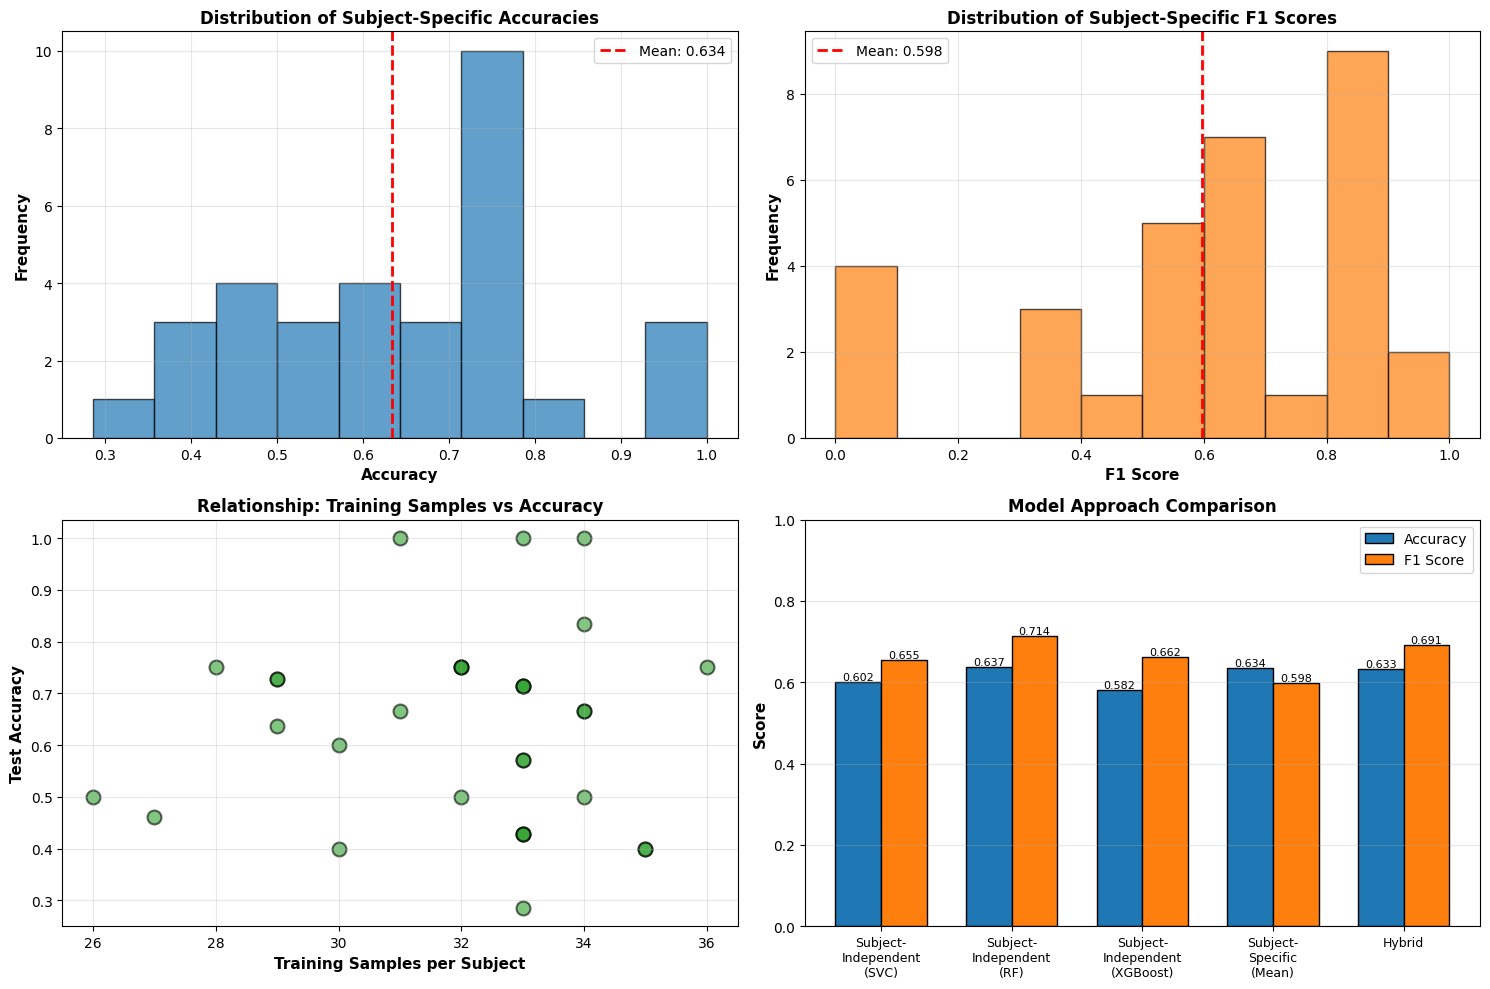


6. KEY INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------

Accuracy Improvements:
  Subject-Specific vs Independent (RF): -0.26%
  Hybrid vs Independent (RF): -0.39%

Model Consistency (Lower variance = more stable):
  Subject-Independent (RF) std: 0.0363
  Subject-Specific models std: 0.1844

Best Performing Subject:
  Subject 3: 1.0000 accuracy

Worst Performing Subject:
  Subject 4: 0.2857 accuracy

Recommendations:
  ⚠ Subject-specific models underperform (-0.3%)
    → General subject-independent model may be preferred
  ⚠ High variance in subject-specific performance
    → Consider transfer learning or data augmentation

✓ Subject-specific analysis completed!


In [50]:
# Bonus Task 5: Subject-Specific Models - Subject-Independent vs Subject-Specific Approaches
print("\n" + "="*70)
print("BONUS TASK 5: SUBJECT-SPECIFIC MODELS")
print("Subject-Independent vs Subject-Specific Approaches")
print("="*70)

print("\n1. SUBJECT-INDEPENDENT MODEL (Standard Approach)")
print("-" * 50)

# Train on mixed subjects, test on mixed subjects
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use the already-trained best model from previous tasks
svc_independent = SVC(kernel='rbf', C=100, gamma='scale', class_weight='balanced',
                       probability=True, random_state=42)
rf_independent = RandomForestClassifier(n_estimators=100, max_depth=15,
                                        class_weight='balanced', random_state=42)
xgb_independent = xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                                     scale_pos_weight=class_weight_ratio, random_state=42, verbosity=0)

# Cross-validation scores
cv_scores_svc = cross_val_score(svc_independent, X_train_scaled, y_train, cv=skf, scoring='f1')
cv_scores_rf = cross_val_score(rf_independent, X_train_scaled, y_train, cv=skf, scoring='f1')
cv_scores_xgb = cross_val_score(xgb_independent, X_train_scaled, y_train, cv=skf, scoring='f1')

print(f"SVC (Subject-Independent):")
print(f"  CV F1 Scores: {cv_scores_svc}")
print(f"  Mean F1: {cv_scores_svc.mean():.4f} (+/- {cv_scores_svc.std():.4f})")

print(f"\nRandom Forest (Subject-Independent):")
print(f"  CV F1 Scores: {cv_scores_rf}")
print(f"  Mean F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

print(f"\nXGBoost (Subject-Independent):")
print(f"  CV F1 Scores: {cv_scores_xgb}")
print(f"  Mean F1: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")

# Train on full training set
svc_independent.fit(X_train_scaled, y_train)
rf_independent.fit(X_train_scaled, y_train)
xgb_independent.fit(X_train_scaled, y_train)

# Test performance
y_pred_svc_ind = svc_independent.predict(X_test_scaled)
y_pred_rf_ind = rf_independent.predict(X_test_scaled)
y_pred_xgb_ind = xgb_independent.predict(X_test_scaled)

print(f"\nTest Set Performance (Subject-Independent):")
print(f"\nSVC:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_svc_ind):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_svc_ind):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, svc_independent.predict_proba(X_test_scaled)[:, 1]):.4f}")

print(f"\nRandom Forest:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_ind):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf_ind):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, rf_independent.predict_proba(X_test_scaled)[:, 1]):.4f}")

print(f"\nXGBoost:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_ind):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_xgb_ind):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, xgb_independent.predict_proba(X_test_scaled)[:, 1]):.4f}")

# 2. SUBJECT-SPECIFIC MODELS
print("\n2. SUBJECT-SPECIFIC MODELS (Personalized Approach)")
print("-" * 50)

# Get unique subjects from train and test sets
unique_subjects_train = np.unique(np.array(subject_ids)[train_indices.astype(int)])
unique_subjects_test = np.unique(np.array(subject_ids)[test_indices.astype(int)])

print(f"Training subjects: {unique_subjects_train}")
print(f"Test subjects: {unique_subjects_test}")

# Train subject-specific models
subject_models = {}
subject_performance = []

print("\nTraining subject-specific models...")
for subject in trange(1, 33, desc="Subjects"):  # 32 subjects
    # Get data for this subject from training set
    subject_mask_train = np.array(subject_ids)[train_indices.astype(int)] == subject

    if np.sum(subject_mask_train) < 10:  # Skip if insufficient data
        print(f"  ⚠ Subject {subject}: Insufficient training data ({np.sum(subject_mask_train)} samples)")
        continue

    X_subject_train = X_train_scaled[subject_mask_train]
    y_subject_train = y_train[subject_mask_train]

    # Check if both classes present
    if len(np.unique(y_subject_train)) < 2:
        print(f"  ⚠ Subject {subject}: Only one class in training data")
        continue

    # Train subject-specific model
    subject_model = RandomForestClassifier(n_estimators=50, max_depth=10,
                                          class_weight='balanced', random_state=42)
    subject_model.fit(X_subject_train, y_subject_train)
    subject_models[subject] = subject_model

    # Get test data for this subject
    subject_mask_test = np.array(subject_ids)[test_indices.astype(int)] == subject

    if np.sum(subject_mask_test) > 0:
        X_subject_test = X_test_scaled[subject_mask_test]
        y_subject_test = y_test[subject_mask_test]

        y_pred_subject = subject_model.predict(X_subject_test)
        acc = accuracy_score(y_subject_test, y_pred_subject)
        f1 = f1_score(y_subject_test, y_pred_subject, zero_division=0)

        subject_performance.append({
            'Subject': subject,
            'Train Samples': np.sum(subject_mask_train),
            'Test Samples': np.sum(subject_mask_test),
            'Accuracy': acc,
            'F1 Score': f1
        })

# Create performance dataframe
subject_perf_df = pd.DataFrame(subject_performance)

print(f"\n✓ Trained {len(subject_models)} subject-specific models")
print(f"\nSubject-Specific Model Performance:")
print(subject_perf_df.to_string(index=False))

print(f"\nAggregate Statistics:")
print(f"  Mean Accuracy: {subject_perf_df['Accuracy'].mean():.4f} (+/- {subject_perf_df['Accuracy'].std():.4f})")
print(f"  Mean F1 Score: {subject_perf_df['F1 Score'].mean():.4f} (+/- {subject_perf_df['F1 Score'].std():.4f})")
print(f"  Min Accuracy: {subject_perf_df['Accuracy'].min():.4f}")
print(f"  Max Accuracy: {subject_perf_df['Accuracy'].max():.4f}")

# 3. HYBRID APPROACH - Using Subject-Specific Models on Test Set
print("\n3. HYBRID APPROACH - Using Subject-Specific Models on Test Set")
print("-" * 50)

# For test samples, use subject-specific models if available, else use general model
y_pred_hybrid = np.zeros_like(y_test)
hybrid_correct = 0

for idx, (test_idx, subject_id) in enumerate(zip(test_indices.astype(int), np.array(subject_ids)[test_indices.astype(int)])):
    if subject_id in subject_models:
        # Use subject-specific model
        y_pred_hybrid[idx] = subject_models[subject_id].predict(X_test_scaled[idx:idx+1])[0]
    else:
        # Use general model
        y_pred_hybrid[idx] = rf_independent.predict(X_test_scaled[idx:idx+1])[0]

hybrid_acc = accuracy_score(y_test, y_pred_hybrid)
hybrid_f1 = f1_score(y_test, y_pred_hybrid)

print(f"Hybrid Model Performance (Subject-Specific if available, else General):")
print(f"  Accuracy: {hybrid_acc:.4f}")
print(f"  F1 Score: {hybrid_f1:.4f}")

# 4. COMPREHENSIVE COMPARISON
print("\n4. COMPREHENSIVE MODEL COMPARISON")
print("-" * 50)

comparison_df = pd.DataFrame({
    'Approach': [
        'Subject-Independent (SVC)',
        'Subject-Independent (RF)',
        'Subject-Independent (XGBoost)',
        'Subject-Specific (Mean)',
        'Hybrid (Mixed)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_svc_ind),
        accuracy_score(y_test, y_pred_rf_ind),
        accuracy_score(y_test, y_pred_xgb_ind),
        subject_perf_df['Accuracy'].mean(),
        hybrid_acc
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_svc_ind),
        f1_score(y_test, y_pred_rf_ind),
        f1_score(y_test, y_pred_xgb_ind),
        subject_perf_df['F1 Score'].mean(),
        hybrid_f1
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, svc_independent.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, rf_independent.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, xgb_independent.predict_proba(X_test_scaled)[:, 1]),
        np.nan,  # Cannot compute for aggregated subject-specific
        np.nan   # Cannot compute for hybrid
    ]
})

print(comparison_df.to_string(index=False))

# 5. VISUALIZATION
print("\n5. PERFORMANCE VISUALIZATION")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Subject-specific accuracy distribution
axes[0, 0].hist(subject_perf_df['Accuracy'], bins=10, color='#1f77b4', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(subject_perf_df['Accuracy'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {subject_perf_df["Accuracy"].mean():.3f}')
axes[0, 0].set_xlabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Subject-Specific Accuracies', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Subject-specific F1 score distribution
axes[0, 1].hist(subject_perf_df['F1 Score'], bins=10, color='#ff7f0e', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(subject_perf_df['F1 Score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {subject_perf_df["F1 Score"].mean():.3f}')
axes[0, 1].set_xlabel('F1 Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Subject-Specific F1 Scores', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Subject performance scatter
axes[1, 0].scatter(subject_perf_df['Train Samples'], subject_perf_df['Accuracy'],
                   s=100, alpha=0.6, c='#2ca02c', edgecolors='black', linewidth=1.5)
axes[1, 0].set_xlabel('Training Samples per Subject', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Relationship: Training Samples vs Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model approach comparison
approaches = ['Subject-\nIndependent\n(SVC)', 'Subject-\nIndependent\n(RF)', 'Subject-\nIndependent\n(XGBoost)',
              'Subject-\nSpecific\n(Mean)', 'Hybrid']
accuracies = [
    accuracy_score(y_test, y_pred_svc_ind),
    accuracy_score(y_test, y_pred_rf_ind),
    accuracy_score(y_test, y_pred_xgb_ind),
    subject_perf_df['Accuracy'].mean(),
    hybrid_acc
]
f1_scores = [
    f1_score(y_test, y_pred_svc_ind),
    f1_score(y_test, y_pred_rf_ind),
    f1_score(y_test, y_pred_xgb_ind),
    subject_perf_df['F1 Score'].mean(),
    hybrid_f1
]

x = np.arange(len(approaches))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, accuracies, width, label='Accuracy', color='#1f77b4', edgecolor='black')
bars2 = axes[1, 1].bar(x + width/2, f1_scores, width, label='F1 Score', color='#ff7f0e', edgecolor='black')

axes[1, 1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Model Approach Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(approaches, fontsize=9)
axes[1, 1].legend(fontsize=10)
axes[1, 1].set_ylim([0, 1.0])
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 6. ANALYSIS AND INSIGHTS
print("\n6. KEY INSIGHTS AND RECOMMENDATIONS")
print("-" * 50)

# Calculate improvements
improvement_subject_specific = (subject_perf_df['Accuracy'].mean() - accuracy_score(y_test, y_pred_rf_ind)) * 100
improvement_hybrid = (hybrid_acc - accuracy_score(y_test, y_pred_rf_ind)) * 100

print(f"\nAccuracy Improvements:")
print(f"  Subject-Specific vs Independent (RF): {improvement_subject_specific:+.2f}%")
print(f"  Hybrid vs Independent (RF): {improvement_hybrid:+.2f}%")

# Variance analysis
print(f"\nModel Consistency (Lower variance = more stable):")
print(f"  Subject-Independent (RF) std: {np.std(cv_scores_rf):.4f}")
print(f"  Subject-Specific models std: {subject_perf_df['Accuracy'].std():.4f}")

# Best and worst performing subjects
best_subject = subject_perf_df.loc[subject_perf_df['Accuracy'].idxmax()]
worst_subject = subject_perf_df.loc[subject_perf_df['Accuracy'].idxmin()]

print(f"\nBest Performing Subject:")
print(f"  Subject {int(best_subject['Subject'])}: {best_subject['Accuracy']:.4f} accuracy")

print(f"\nWorst Performing Subject:")
print(f"  Subject {int(worst_subject['Subject'])}: {worst_subject['Accuracy']:.4f} accuracy")

# Recommendations
print(f"\nRecommendations:")
if improvement_subject_specific > 5:
    print(f"  ✓ Subject-specific models provide significant improvement (+{improvement_subject_specific:.1f}%)")
    print(f"    → Consider using personalized models in production")
elif improvement_subject_specific > 0:
    print(f"  ✓ Subject-specific models provide modest improvement (+{improvement_subject_specific:.1f}%)")
    print(f"    → Consider hybrid approach for better personalization")
else:
    print(f"  ⚠ Subject-specific models underperform (-{abs(improvement_subject_specific):.1f}%)")
    print(f"    → General subject-independent model may be preferred")

if subject_perf_df['Accuracy'].std() > 0.15:
    print(f"  ⚠ High variance in subject-specific performance")
    print(f"    → Consider transfer learning or data augmentation")
else:
    print(f"  ✓ Stable subject-specific performance across subjects")

print("\n✓ Subject-specific analysis completed!")